In [49]:
#  Copyright (c) 2019 5GTANGO, Paderborn University
# ALL RIGHTS RESERVED.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Neither the name of the SONATA-NFV, 5GTANGO, Paderborn University
# nor the names of its contributors may be used to endorse or promote
# products derived from this software without specific prior written
# permission.
#
# This work has also been performed in the framework of the 5GTANGO project,
# funded by the European Commission under Grant number 761493 through
# the Horizon 2020 and 5G-PPP programmes. The authors would like to
# acknowledge the contributions of their colleagues of the SONATA
# partner consortium (www.5gtango.eu).

In [50]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns

# global plotting settings
plt.rcParams.update({'font.size': 20})

In [51]:
results_file = 'times_ns1_ns2_50runs.pkl'
df = pd.read_pickle(results_file)
df.head()

,instantiation,packaging,service,total,uploading
0,3.762881,1.048635,ns1,4.974268,0.162752
1,3.452802,0.801207,ns1,4.416270,0.162261
2,3.722683,0.701120,ns1,4.574893,0.151090
3,3.529324,0.716238,ns1,4.409129,0.163567
4,3.604731,0.711161,ns1,4.474845,0.158953


In [52]:
# stats for NS1 (to be used in deliverable)
df.loc[df['service'] == 'ns1'].describe()

,instantiation,packaging,total,uploading
count,50.000000,50.000000,50.000000,50.000000
mean,3.383252,0.707223,4.246318,0.155843
std,0.166058,0.058585,0.197616,0.006585
min,3.109689,0.666634,3.944642,0.144192
25%,3.240762,0.685533,4.081511,0.151243
50%,3.377414,0.694051,4.227606,0.154952
75%,3.488612,0.704158,4.376635,0.159582
max,3.778865,1.048635,4.974268,0.179338


In [53]:
# stats for NS2 (to be used in deliverable)
df.loc[df['service'] == 'ns2'].describe()

,instantiation,packaging,total,uploading
count,50.000000,50.000000,50.000000,50.000000
mean,2.559891,0.729286,3.423341,0.134164
std,0.072613,0.118982,0.148608,0.007445
min,2.405099,0.659244,3.193834,0.124057
25%,2.515052,0.674594,3.344404,0.128977
50%,2.550688,0.685920,3.389886,0.132780
75%,2.590530,0.712781,3.458592,0.136968
max,2.795256,1.165832,3.957522,0.160167


In [54]:
# get mean times for ns1 and ns2
pkg_avg = [df.loc[df['service'] == 'ns1']['packaging'].mean(), df.loc[df['service'] == 'ns2']['packaging'].mean()]
up_avg = [df.loc[df['service'] == 'ns1']['uploading'].mean(), df.loc[df['service'] == 'ns2']['uploading'].mean()]
inst_avg = [df.loc[df['service'] == 'ns1']['instantiation'].mean(), df.loc[df['service'] == 'ns2']['instantiation'].mean()]

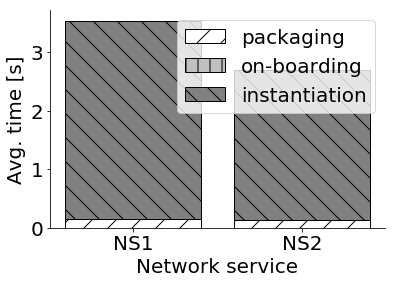

In [55]:
# plot stacked barplots with avg times per service
ns = [0, 1]
times = ['packaging', 'on-boarding', 'instantiation']

plt.bar(ns, pkg_avg, color='white', edgecolor='black', hatch='/')
plt.bar(ns, up_avg, bottom=pkg_avg, color='silver', edgecolor='black', hatch='|')
plt.bar(ns, inst_avg, bottom=up_avg, color='gray', edgecolor='black', hatch='\\')

plt.xticks(ns, ['NS1', 'NS2'])
plt.xlabel("Network service")
plt.ylabel("Avg. time [s]")
plt.legend(times)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('plots/barplot.pdf', bbox_inches='tight')
plt.show()

In [56]:
# plot CDF of times in specified column name
def plot_cdf(column_name, plot_name):
    ns1_times = df.loc[df['service'] == 'ns1'][column_name]
    ns2_times = df.loc[df['service'] == 'ns2'][column_name]
    num_times = ns1_times.shape[0]

    plt.hist(ns1_times, num_times, density=1, histtype='step', cumulative=True)
    plt.hist(ns2_times, num_times, density=1, histtype='step', cumulative=True)
    # drop at the end is an artifact of this hist plotting function

    plt.xlabel(f"{plot_name} times [s]")
    plt.ylabel("CDF")
    plt.legend(['NS1', 'NS2'], loc=4)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.savefig(f'plots/cdf_{column_name}.pdf', bbox_inches='tight')
    plt.show()

In [57]:
# nicer CDF plots
# from https://github.com/mpeuster/paper-ijnm-jouornal-sdn-handover/blob/master/evaluation/eval_packet_delay_cdf.ipynb

# calc and plot CDF (used within other function)
def calc_plot_cdf(sorted_list, bin_range, bins=1000, ls='-'):
    counts, bins = np.histogram(sorted_list, range=bin_range, bins=bins)
    cdf = np.cumsum(counts)/np.sum(counts)
    plt.plot(np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2], np.vstack((cdf, cdf)).T.flatten(), antialiased=True, lw=2, ls=ls, color='black')

def plot_nicer_cdf(column_name, plot_name):
    # select times for NS1 and NS2
    ns1_times = df.loc[df['service'] == 'ns1'][column_name]
    ns1_times_sortlist = np.sort(ns1_times.tolist())
    ns2_times = df.loc[df['service'] == 'ns2'][column_name]
    ns2_times_sortlist = np.sort(ns2_times.tolist())

    # calc and plot CDFs
    min_time = min(ns1_times_sortlist.min(), ns2_times_sortlist.min())
    max_time = max(ns1_times_sortlist.max(), ns2_times_sortlist.max())
    calc_plot_cdf(ns1_times_sortlist, [min_time, max_time], ls='-')    
    calc_plot_cdf(ns2_times_sortlist, [min_time, max_time], ls=':')
    
    # polish, save, and show plots
    plt.ylim(0, 1)
    plt.xlabel(f"{plot_name} times [s]")
    plt.ylabel("CDF")
    plt.legend(['NS1', 'NS2'], loc=4)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.savefig(f'plots/cdf_{column_name}.pdf', bbox_inches='tight')

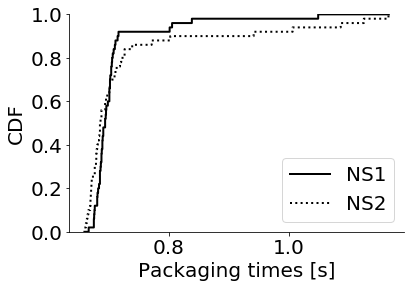

In [58]:
plot_nicer_cdf('packaging', 'Packaging')

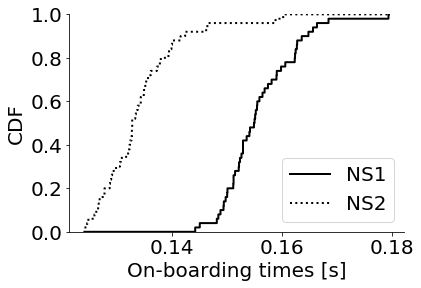

In [59]:
plot_nicer_cdf('uploading', 'On-boarding')

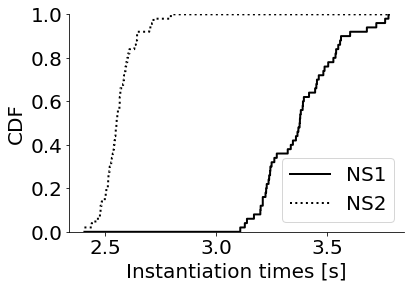

In [60]:
plot_nicer_cdf('instantiation', 'Instantiation')

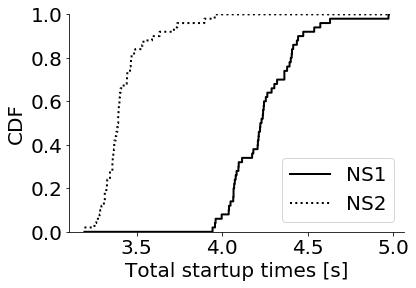

In [61]:
plot_nicer_cdf('total', 'Total startup')

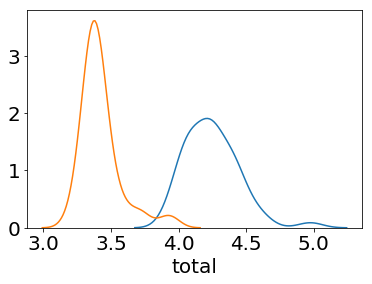

In [62]:
# histogram
ns1_times = df.loc[df['service'] == 'ns1']['total']
ns2_times = df.loc[df['service'] == 'ns2']['total']
sns.distplot(ns1_times, hist=False)
sns.distplot(ns2_times, hist=False)